In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_sample = pd.read_csv('../data/train_sample.csv')
train_sample.head()

,start_point,end_point,time_of_day,day_of_week,traffic_condition,event_count,is_holiday,vehicle_density,population_density,weather,public_transport_availability,historical_delay_factor,travel_time
0,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),day,Sunday,NaN,9,1,NaN,high,NaN,1,0.878909,26.907612
1,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),morning,Thursday,NaN,7,1,medium,high,NaN,1,1.081668,27.489129
2,Central Jakarta (Jakarta Pusat),East Jakarta (Jakarta Timur),morning,Thursday,NaN,7,0,medium,low,NaN,2,1.192379,27.228978
3,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),morning,Friday,10.0,9,0,medium,high,fog,1,0.833348,33.943970
4,Central Jakarta (Jakarta Pusat),West Jakarta (Jakarta Barat),day,Tuesday,NaN,7,0,medium,high,rain,2,0.966819,20.603115


In [3]:
train_sample['day_of_week'].value_counts()

day_of_week
Monday       5781
Wednesday    5746
Thursday     5744
Friday       5711
Tuesday      5707
Saturday     5666
Sunday       5645
Name: count, dtype: int64

In [138]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   start_point                    40000 non-null  object 
 1   end_point                      40000 non-null  object 
 2   time_of_day                    40000 non-null  object 
 3   day_of_week                    40000 non-null  object 
 4   traffic_condition              25599 non-null  float64
 5   event_count                    40000 non-null  int64  
 6   is_holiday                     40000 non-null  int64  
 7   vehicle_density                25622 non-null  object 
 8   population_density             25552 non-null  object 
 9   weather                        25571 non-null  object 
 10  public_transport_availability  40000 non-null  int64  
 11  historical_delay_factor        40000 non-null  float64
 12  travel_time                    40000 non-null 

# Exploratory Data Analysis

## Feature Engineering

In [38]:
corr = train_sample.select_dtypes(include=('int', 'float')).corr()
high_corr = corr['travel_time'].sort_values(ascending=False)
print(high_corr)

travel_time                      1.000000
public_transport_availability    0.246958
historical_delay_factor          0.052816
is_holiday                      -0.000366
traffic_condition               -0.001405
event_count                     -0.009502
Name: travel_time, dtype: float64


In [4]:
train_sample['start_point'] = train_sample['start_point'].str.split(' (', regex=False).str[0]
train_sample['end_point'] = train_sample['end_point'].str.split(' (', regex=False).str[0]

In [5]:
train_sample['route'] = train_sample['start_point'] + ' to ' + train_sample['end_point']

train_sample = train_sample.drop(['start_point', 'end_point'], axis=1)

In [41]:
# Traffic severity categories
traffic_bins = [2, 4, 7, 10]
traffic_labels = ['light', 'moderate', 'heavy']
train_sample['traffic_severity'] = pd.cut(train_sample['traffic_condition'], bins=traffic_bins, labels=traffic_labels)

# High traffic indicator (>= 8)
#train_sample['high_traffic'] = (train_sample['traffic_condition'] >= 8.0).astype(int)

# Extreme traffic indicator (>= 9)
#train_sample['extreme_traffic'] = (train_sample['traffic_condition'] >= 9.0).astype(int)
train_sample = train_sample.drop(['traffic_condition'], axis=1)

In [6]:
train_sample['day_of_week'] = train_sample['day_of_week'].str.lower()

# Buat fitur is_weekend (1 untuk Sabtu/Minggu, 0 untuk hari lain)
train_sample['is_weekend'] = train_sample['day_of_week'].apply(
    lambda x: 1 if x in ['saturday', 'sunday'] else 0
)

In [7]:
# 2. Gabungkan route dengan day_of_week
train_sample['route_day'] = train_sample['route'] + '_' + train_sample['day_of_week']

# 3. Gabungkan route dengan time_of_day (opsional)
train_sample['route_time'] = train_sample['route'] + '_' + train_sample['time_of_day']

# 4. Gabungkan route, hari, dan waktu sekaligus (opsional)
train_sample['route_day_time'] = train_sample['route'] + '_' + train_sample['day_of_week'] + '_' + train_sample['time_of_day']

In [120]:
train_sample['route_day_time'].value_counts()

route_day_time
Central Jakarta to West Jakarta_monday_night       171
Central Jakarta to South Jakarta_thursday_day      168
Central Jakarta to East Jakarta_thursday_night     167
Central Jakarta to South Jakarta_saturday_night    166
North Jakarta to South Jakarta_thursday_evening    166
                                                  ... 
North Jakarta to East Jakarta_friday_morning       117
North Jakarta to South Jakarta_sunday_day          116
West Jakarta to East Jakarta_thursday_morning      115
South Jakarta to East Jakarta_thursday_night       107
West Jakarta to South Jakarta_friday_night         106
Name: count, Length: 280, dtype: int64

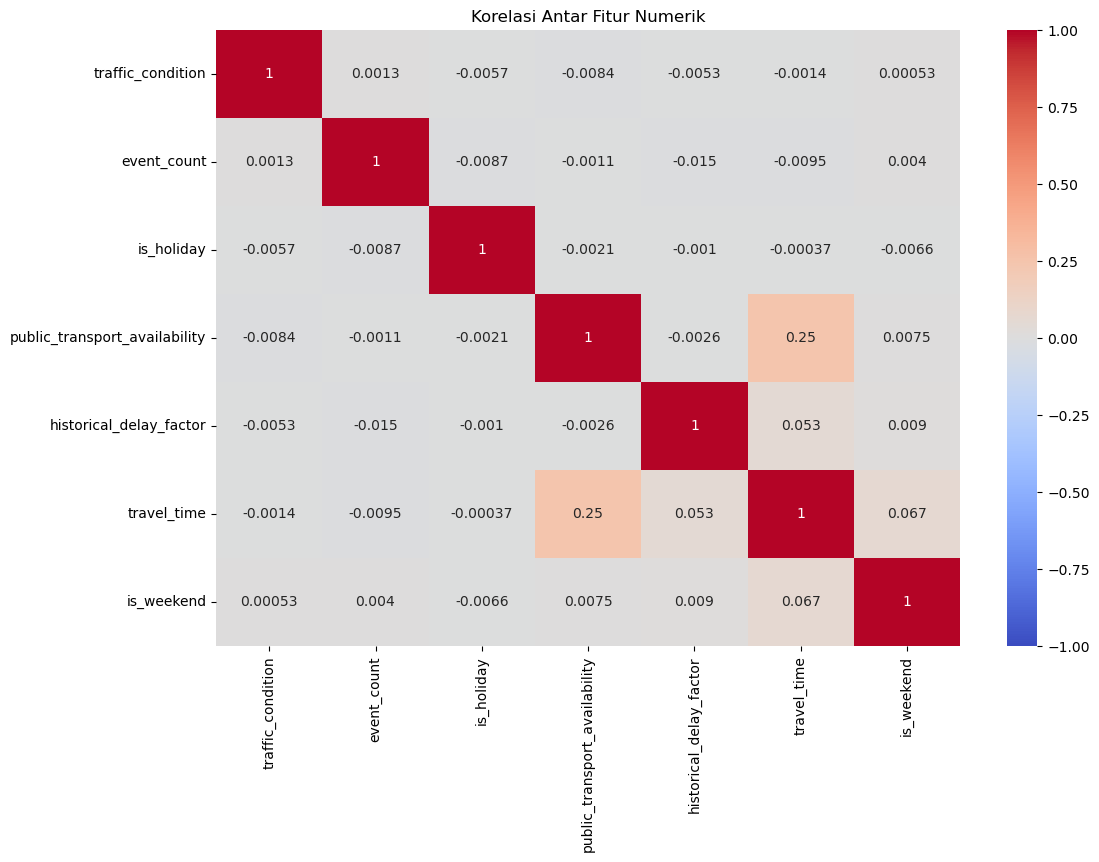

In [7]:
# Hitung matriks korelasi
corr_matrix = train_sample.select_dtypes(include=['float64', 'int64']).corr()

# Tampilkan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Korelasi Antar Fitur Numerik")
plt.show()

In [8]:
high_corr_pairs = corr_matrix.abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs[0] > 0.8) &  # Threshold korelasi
    (high_corr_pairs['level_0'] != high_corr_pairs['level_1'])  # Hindari diagonal
]
print("Pasangan Fitur Berkorelasi Tinggi:")
print(high_corr_pairs.sort_values(0, ascending=False))

Pasangan Fitur Berkorelasi Tinggi:
Empty DataFrame
Columns: [level_0, level_1, 0]
Index: []


## Checking Null for Imputation

In [123]:
for col in train_sample.columns:
    
    total_value = train_sample[col].value_counts().sum()
    total_value_pct = (total_value/len(train_sample))*100
    if total_value_pct < 100.0:
        print(f"'{col}' -->  {100 - total_value_pct:.2f}% data missing")
    else:
        continue

'traffic_condition' -->  36.00% data missing
'vehicle_density' -->  35.95% data missing
'population_density' -->  36.12% data missing
'weather' -->  36.07% data missing


### Imput NaN Object Value with Missing or Unknown

In [8]:
obj_nan = ['vehicle_density', 'population_density', 'weather']
for col in obj_nan:
    train_sample[col] = train_sample[col].str.lower()
    train_sample[col] = train_sample[col].replace('nan',np.nan)
    train_sample[col] = train_sample[col].fillna('missing')

In [10]:
for col in train_sample.columns:
    
    total_value = train_sample[col].value_counts().sum()
    total_value_pct = (total_value/len(train_sample))*100
    if total_value_pct < 100.0:
        print(f"'{col}' -->  {100 - total_value_pct:.2f}% data missing")
    else:
        continue

'traffic_condition' -->  36.00% data missing


### Add feature is_missing for traffic_condition

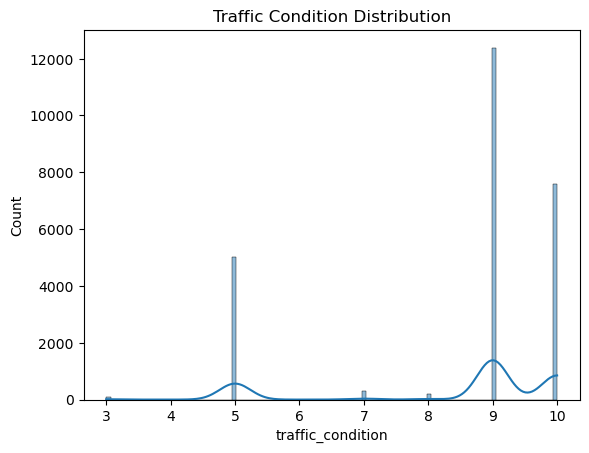

In [22]:
sns.histplot(train_sample['traffic_condition'], kde=True)
plt.title("Traffic Condition Distribution")
plt.show()

In [9]:
train_sample['traffic_condition_missing'] = train_sample['traffic_condition'].isna().astype(int)
#train_sample['traffic_severity_missing'] = train_sample['traffic_severity'].isna().astype(int)

In [10]:
train_sample['traffic_condition'] = train_sample['traffic_condition'].fillna(train_sample['traffic_condition'].mode()[0])
#train_sample['traffic_severity'] = train_sample['traffic_severity'].fillna(train_sample['traffic_severity'].mode()[0])

In [79]:
for col in train_sample.columns:
    
    total_value = train_sample[col].value_counts().sum()
    total_value_pct = (total_value/len(train_sample))*100
    if total_value_pct < 100.0:
        print(f"'{col}' -->  {100 - total_value_pct:.2f}% data missing")
    else:
        continue

In [80]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   time_of_day                    40000 non-null  object 
 1   day_of_week                    40000 non-null  object 
 2   traffic_condition              40000 non-null  float64
 3   event_count                    40000 non-null  int64  
 4   is_holiday                     40000 non-null  int64  
 5   vehicle_density                40000 non-null  object 
 6   population_density             40000 non-null  object 
 7   weather                        40000 non-null  object 
 8   public_transport_availability  40000 non-null  int64  
 9   historical_delay_factor        40000 non-null  float64
 10  travel_time                    40000 non-null  float64
 11  route                          40000 non-null  object 
 12  is_weekend                     40000 non-null 

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Hitung VIF untuk setiap fitur numerik
vif_data = pd.DataFrame()
vif_data["feature"] = train_sample.select_dtypes(include=['float64', 'int64']).columns
vif_data["VIF"] = [variance_inflation_factor(
    train_sample.select_dtypes(include=['float64', 'int64']).values, i) 
    for i in range(len(vif_data["feature"]))
]

print(vif_data.sort_values("VIF", ascending=False))

                         feature       VIF
3        historical_delay_factor  9.997921
2  public_transport_availability  5.936711
4                    travel_time  5.299159
0                    event_count  3.411519
1                     is_holiday  1.962466
6       traffic_severity_missing  1.544742
5                     is_weekend  1.394653


## Detect and Handle Outliers

In [58]:
outlier_list = []
list_int = []
list_int = train_sample.select_dtypes(include=('int', 'float')).columns.to_list()
print('Checking for outliers')

for col in list_int:
    Q1 = train_sample[col].quantile(.25)
    Q3 = train_sample[col].quantile(.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR*1.5
    upper_bound = Q3 + IQR*1.5

    outlier_count = train_sample[(train_sample[col]<lower_bound) | (train_sample[col]>upper_bound)].shape[0]
    outlier_pct = outlier_count/len(train_sample)*100

    print(f"{col} : {outlier_count} Outlier({outlier_pct:.2f}%)")
    if outlier_count != 0:
        outlier_list.append(col)
    else:
        continue

Checking for outliers
traffic_condition : 13209 Outlier(33.02%)
event_count : 706 Outlier(1.76%)
is_holiday : 0 Outlier(0.00%)
public_transport_availability : 0 Outlier(0.00%)
historical_delay_factor : 383 Outlier(0.96%)
travel_time : 465 Outlier(1.16%)
is_weekend : 0 Outlier(0.00%)
traffic_condition_missing : 0 Outlier(0.00%)
traffic_severity_missing : 0 Outlier(0.00%)


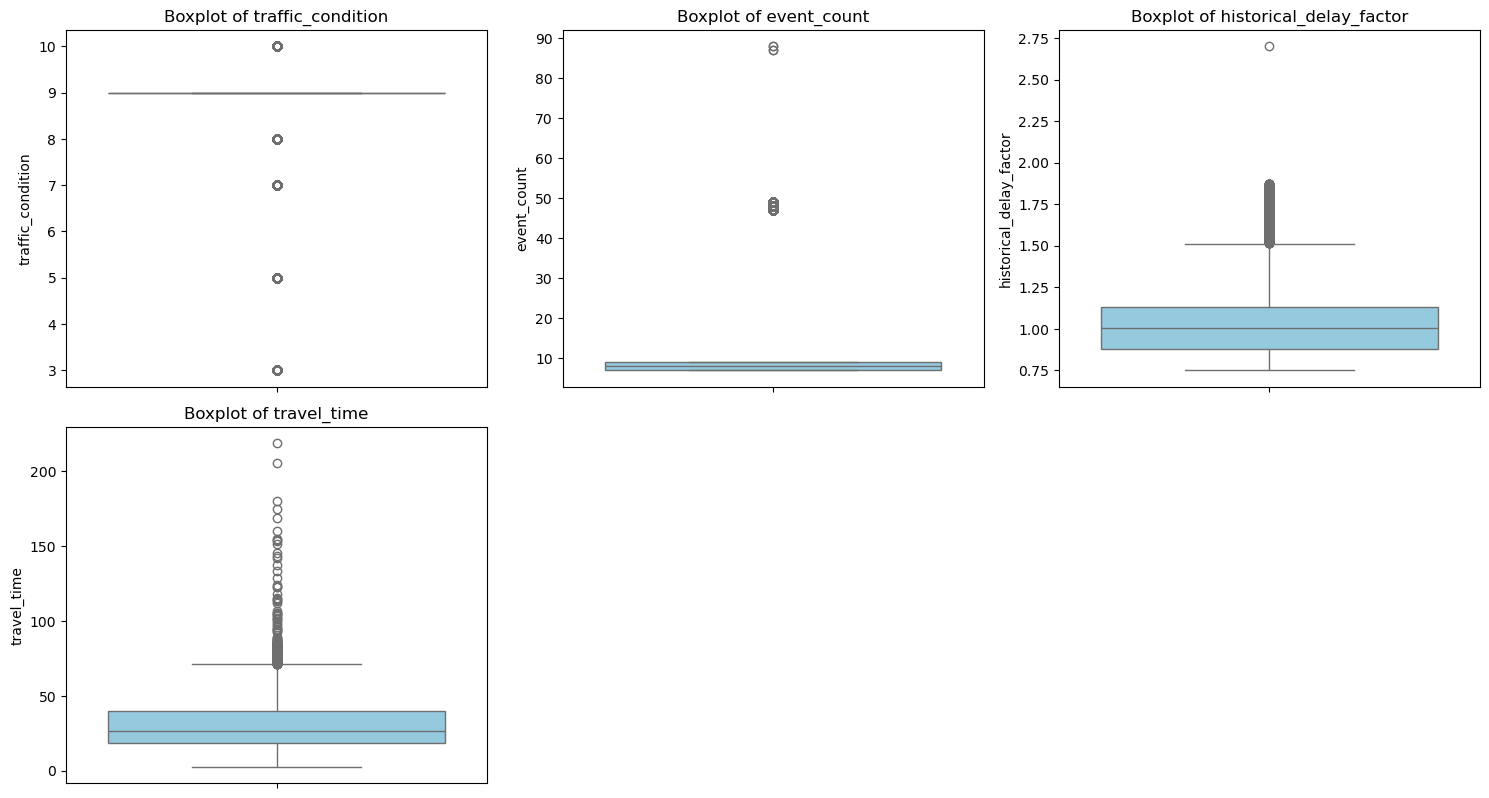

In [28]:
# Kolom-kolom yang ingin dilihat outliernya
columns_to_check = ['traffic_condition', 'event_count', 'historical_delay_factor', 'travel_time']

# Tentukan ukuran plot
plt.figure(figsize=(15, 12))

# Loop untuk membuat subplot boxplot setiap kolom
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=train_sample[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

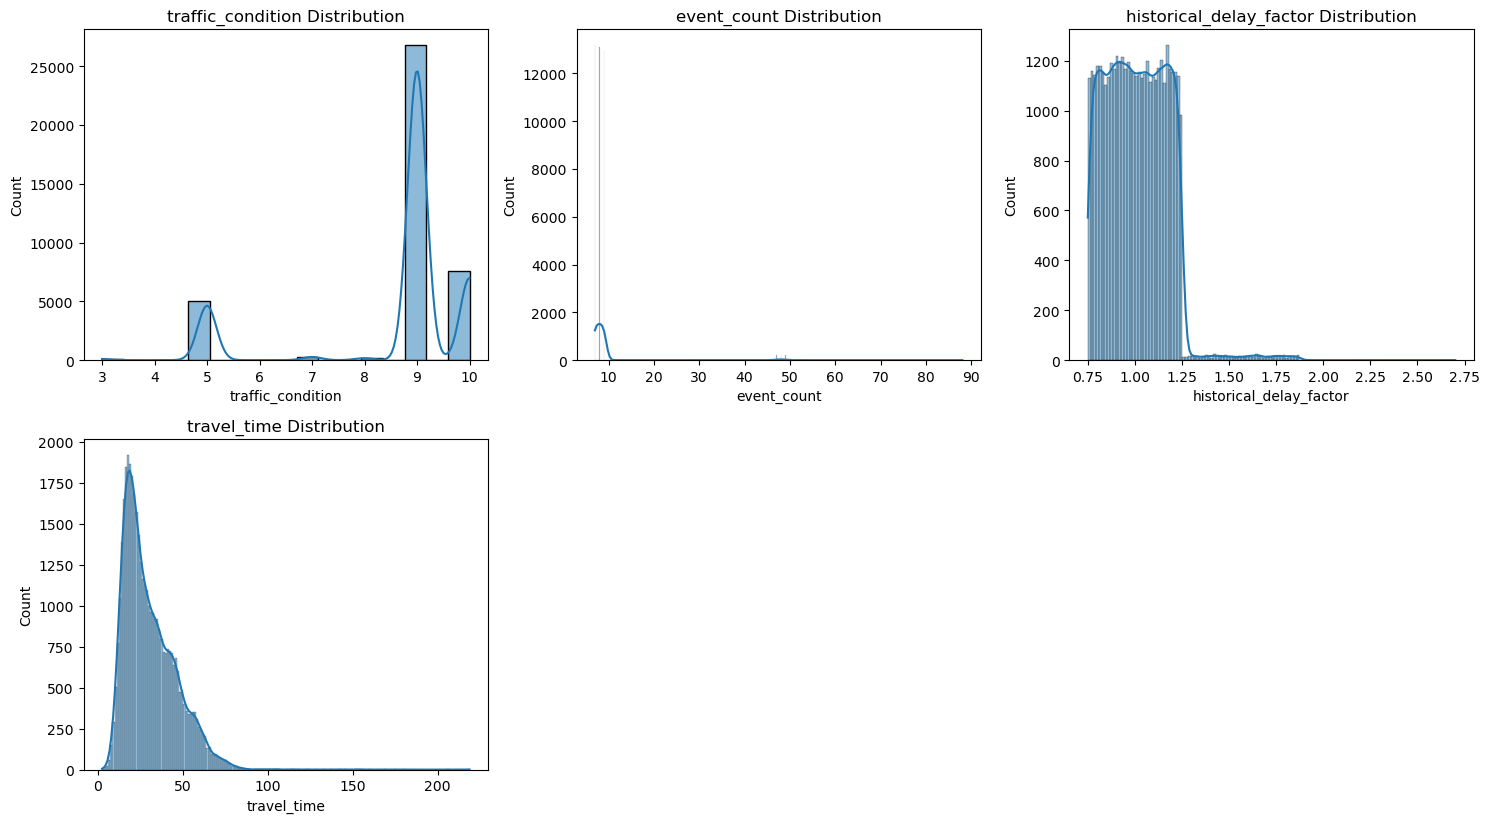

In [29]:
# Kolom-kolom yang ingin dilihat outliernya
columns_to_check_dist = ['traffic_condition', 'event_count', 'historical_delay_factor', 'travel_time']

# Tentukan ukuran plot
plt.figure(figsize=(15, 12))

# Loop untuk membuat subplot boxplot setiap kolom
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_sample[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.tight_layout()

plt.show()


### Handle Event Count with Log Transform

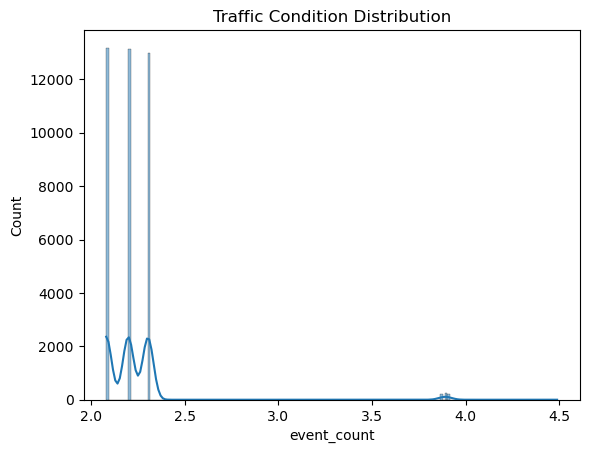

In [30]:
sns.histplot((train_sample['event_count']), kde=True)
plt.title("Traffic Condition Distribution")
plt.show()

In [11]:
# Log transform
train_sample['event_count'] = np.log1p(train_sample['event_count'])

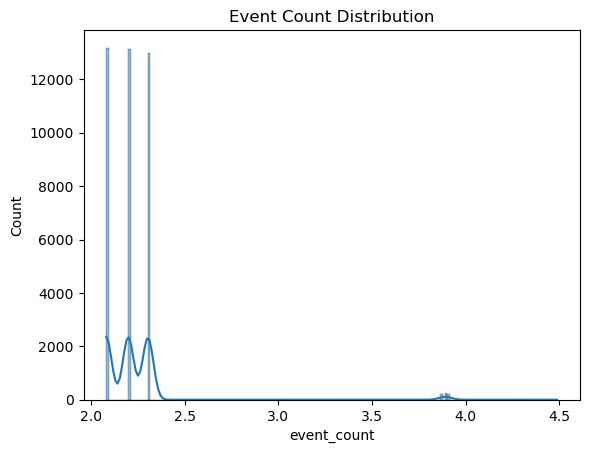

In [129]:
sns.histplot(train_sample['event_count'], kde=True)
plt.title("Event Count Distribution")
plt.show()

# Data Pre-Proccessing

In [12]:
y = train_sample['travel_time']
X = train_sample.drop(['travel_time'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   time_of_day                    40000 non-null  object 
 1   day_of_week                    40000 non-null  object 
 2   traffic_condition              40000 non-null  float64
 3   event_count                    40000 non-null  float64
 4   is_holiday                     40000 non-null  int64  
 5   vehicle_density                40000 non-null  object 
 6   population_density             40000 non-null  object 
 7   weather                        40000 non-null  object 
 8   public_transport_availability  40000 non-null  int64  
 9   historical_delay_factor        40000 non-null  float64
 10  route                          40000 non-null  object 
 11  is_weekend                     40000 non-null  int64  
 12  route_day                      40000 non-null 

In [24]:
X['historical_delay_factor'].max()

np.float64(2.701010448794384)

## Encoding

In [35]:
X_train_num = X_train._get_numeric_data()
X_test_num = X_test._get_numeric_data()

X_train_cat = X_train.drop(list(X_train_num.columns.values), axis=1)
X_test_cat = X_test.drop(list(X_test_num.columns.values), axis=1)

X_train_cat.head()

,time_of_day,day_of_week,vehicle_density,population_density,weather,route,route_day,route_time,route_day_time
25205,night,thursday,missing,high,missing,Central Jakarta to North Jakarta,Central Jakarta to North Jakarta_thursday,Central Jakarta to North Jakarta_night,Central Jakarta to North Jakarta_thursday_night
5266,night,wednesday,low,missing,storm,North Jakarta to South Jakarta,North Jakarta to South Jakarta_wednesday,North Jakarta to South Jakarta_night,North Jakarta to South Jakarta_wednesday_night
6876,night,wednesday,medium,medium,fog,Central Jakarta to North Jakarta,Central Jakarta to North Jakarta_wednesday,Central Jakarta to North Jakarta_night,Central Jakarta to North Jakarta_wednesday_night
18031,night,wednesday,missing,missing,rain,West Jakarta to South Jakarta,West Jakarta to South Jakarta_wednesday,West Jakarta to South Jakarta_night,West Jakarta to South Jakarta_wednesday_night
21984,day,friday,missing,missing,fog,West Jakarta to East Jakarta,West Jakarta to East Jakarta_friday,West Jakarta to East Jakarta_day,West Jakarta to East Jakarta_friday_day


### OneHot Encoding

In [36]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

#cat_feature = X_train_cat[['start_point','end_point', 'time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather']]
#cat_feature_test = X_test_cat[['start_point','end_point', 'time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather']]
cat_feature = X_train_cat[['time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather', 'route']]
cat_feature_test = X_test_cat[['time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather', 'route']]

cat_encoded = ohe.fit_transform(cat_feature)
cat_encoded_test = ohe.transform(cat_feature_test)

cat_encoded_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(cat_feature.columns), index=X_train_cat.index)
cat_encoded_df_test = pd.DataFrame(cat_encoded_test, columns=ohe.get_feature_names_out(cat_feature_test.columns), index=X_test_cat.index)

#X_train_cat = X_train_cat.drop(['start_point','end_point', 'time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather'], axis=1)
#X_train_cat = pd.concat([X_train_cat, cat_encoded_df], axis=1)
X_train_cat = X_train_cat.drop(['time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather', 'route'], axis=1)
X_train_cat = pd.concat([X_train_cat, cat_encoded_df], axis=1)

#X_test_cat = X_test_cat.drop(['start_point','end_point', 'time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather'], axis=1)
X_test_cat = X_test_cat.drop(['time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather', 'route'], axis=1)
X_test_cat = pd.concat([X_test_cat, cat_encoded_df_test], axis=1)

## Target Encoding

In [37]:
X_train_encoded = X_train_cat.copy()
X_test_encoded = X_test_cat.copy()

target_encode_cols = ['route_day', 'route_time', 'route_day_time']

for col in target_encode_cols:
    # Menggabungkan X dan y agar bisa groupby dengan y_train
    temp_df = X_train_cat.copy()
    temp_df['target'] = y_train.values

    # Hitung rata-rata target untuk setiap kategori
    mean_encoded = temp_df.groupby(col)['target'].mean()

    # Mapping ke training dan test
    X_train_encoded[col] = X_train_cat[col].map(mean_encoded)
    global_mean = y_train.mean()
    X_test_encoded[col] = X_test_cat[col].map(mean_encoded).fillna(global_mean)

In [38]:
# Gabungkan kembali
X_train_concat = pd.concat([X_train_num, X_train_encoded], axis=1)
X_test_concat = pd.concat([X_test_num, X_test_encoded], axis=1)

In [19]:
# Join Numerical dan Categorical Data
X_train_concat = pd.concat([X_train_num,
                            X_train_cat],
                           axis = 1)

X_test_concat = pd.concat([X_test_num,
                          X_test_cat],
                         axis=1)

In [39]:
X_train_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32000 entries, 25205 to 9256
Data columns (total 44 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   traffic_condition                       32000 non-null  float64
 1   event_count                             32000 non-null  float64
 2   is_holiday                              32000 non-null  int64  
 3   public_transport_availability           32000 non-null  int64  
 4   historical_delay_factor                 32000 non-null  float64
 5   is_weekend                              32000 non-null  int64  
 6   traffic_condition_missing               32000 non-null  int64  
 7   route_day                               32000 non-null  float64
 8   route_time                              32000 non-null  float64
 9   route_day_time                          32000 non-null  float64
 10  time_of_day_day                         32000 non-null  floa

## Check Null and Handle It

In [138]:
for col in X_train_concat.columns:
    
    total_value = X_train_concat[col].value_counts().sum()
    total_value_pct = (total_value/len(X_train_concat))*100
    if total_value_pct < 100.0:
        print(f"'{col}' -->  {100 - total_value_pct:.2f}% data missing")
    else:
        continue

## Standarization

In [40]:
scaler = StandardScaler()

# Select only numerical columns (excluding datetime)
num_features = X_train_concat.select_dtypes(include=['float64', 'int64']).columns
# Fitur yang perlu diskalakan
#num_features = ['traffic_condition', 'public_transport_availability', 'historical_delay_factor', 'vehicle_density_encoded', 
#                'population_density_encoded', 'event_count_category_encoded']
'''categorical_features_encoded = ['is_holiday', 'start_point_Central Jakarta (Jakarta Pusat)', 'start_point_North Jakarta (Jakarta Utara)', 
                                'start_point_South Jakarta (Jakarta Selatan)', 
                                'start_point_West Jakarta (Jakarta Barat)', 'end_point_East Jakarta (Jakarta Timur)', 
                                'end_point_North Jakarta (Jakarta Utara)', 
                                'end_point_South Jakarta (Jakarta Selatan)', 'end_point_West Jakarta (Jakarta Barat)', 'time_of_day_day', 
                                'time_of_day_evening', 
                                'time_of_day_morning', 'time_of_day_night', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 
                                'day_of_week_Sunday', 
                                'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'weather_clear', 'weather_fog', 
                                'weather_missing', 
                                'weather_rain', 'weather_storm', 'vehicle_density_missing', 'population_density_missing']
#features_to_scale = ['sold_price', 'sqft']'''

# Menskalakan fitur yang dipilih menggunakan StandardScaler
X_train_num_scaled = scaler.fit_transform(X_train_concat[num_features])
X_test_num_scaled = scaler.transform(X_test_concat[num_features])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_num_scaled, 
                            columns=num_features, 
                            index=X_train_concat.index)

X_test_scaled = pd.DataFrame(X_test_num_scaled,
                           columns=num_features,
                           index=X_test_concat.index)

# 5. Pilih kolom kategorikal (yang tidak di-scale) dari DataFrame asli
#X_train_categorical = X_train_concat[categorical_features_encoded]
#X_test_categorical = X_test_concat[categorical_features_encoded]

# 6. GABUNGKAN KEMBALI kedua DataFrame tersebut
#X_train_scaled = pd.concat([X_train_scaled, X_train_categorical], axis=1)
#X_test_scaled = pd.concat([X_test_scaled, X_test_categorical], axis=1)

# Optionally add back the datetime columns
#X_train_scaled['sold_date'] = X_train_concat['sold_date']
#X_test_scaled['sold_date'] = X_test_concat['sold_date']

# Now you can use .head()
X_train_scaled.head()

,traffic_condition,event_count,is_holiday,public_transport_availability,historical_delay_factor,is_weekend,traffic_condition_missing,route_day,route_time,route_day_time,...,route_Central Jakarta to East Jakarta,route_Central Jakarta to North Jakarta,route_Central Jakarta to South Jakarta,route_Central Jakarta to West Jakarta,route_North Jakarta to East Jakarta,route_North Jakarta to South Jakarta,route_North Jakarta to West Jakarta,route_South Jakarta to East Jakarta,route_West Jakarta to East Jakarta,route_West Jakarta to South Jakarta
25205,0.906035,-0.589580,-0.998127,0.746513,0.287417,-0.625205,-0.748373,0.218324,-0.136682,-0.196991,...,-0.332928,3.006267,-0.33368,-0.338862,-0.331769,-0.330490,-0.335528,-0.332001,-0.330083,-0.335297
5266,0.234991,0.325363,1.001877,-0.740287,-0.962869,-0.625205,-0.748373,0.911608,0.406286,0.362229,...,-0.332928,-0.332638,-0.33368,-0.338862,-0.331769,3.025807,-0.335528,-0.332001,-0.330083,-0.335297
6876,0.234991,-0.589580,-0.998127,0.746513,0.467229,-0.625205,1.336232,0.221156,-0.136682,-0.156630,...,-0.332928,3.006267,-0.33368,-0.338862,-0.331769,-0.330490,-0.335528,-0.332001,-0.330083,-0.335297
18031,0.234991,-0.589580,1.001877,-0.740287,-0.765427,-0.625205,1.336232,-0.343516,-0.574894,-0.598176,...,-0.332928,-0.332638,-0.33368,-0.338862,-0.331769,-0.330490,-0.335528,-0.332001,-0.330083,2.982426
21984,0.234991,0.325363,-0.998127,0.746513,0.783462,-0.625205,-0.748373,1.241367,0.634791,0.962900,...,-0.332928,-0.332638,-0.33368,-0.338862,-0.331769,-0.330490,-0.335528,-0.332001,3.029541,-0.335297


In [140]:
corr_matrix = X_train_scaled.select_dtypes(include=['float64', 'int64']).corr()

high_corr_pairs = corr_matrix.abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs[0] > 0.8) &  # Threshold korelasi
    (high_corr_pairs['level_0'] != high_corr_pairs['level_1'])  # Hindari diagonal
]
print("Pasangan Fitur Berkorelasi Tinggi:")
print(high_corr_pairs.sort_values(0, ascending=False))

Pasangan Fitur Berkorelasi Tinggi:
            level_0         level_1         0
404  route_day_time      route_time  0.981554
361      route_time  route_day_time  0.981554
403  route_day_time       route_day  0.941910
317       route_day  route_day_time  0.941910
316       route_day      route_time  0.929473
359      route_time       route_day  0.929473


In [105]:
# Gabungkan fitur dan target menjadi satu DataFrame
df_corr = X_train_scaled.copy()
df_corr['target'] = y_train

# Hitung korelasi
corr_matrix = df_corr.corr()

# Ambil korelasi antara fitur dan target
target_corr = corr_matrix['target'].drop('target').sort_values(ascending=False)

print(target_corr)

start_point_North Jakarta        0.423579
public_transport_availability    0.249521
end_point_East Jakarta           0.245321
time_of_day_evening              0.196624
start_point_West Jakarta         0.134259
end_point_North Jakarta          0.107407
vehicle_density_low              0.105173
day_of_week_Friday               0.103690
time_of_day_morning              0.086930
historical_delay_factor          0.052362
day_of_week_Sunday               0.042287
day_of_week_Saturday             0.041863
population_density_high          0.023150
vehicle_density_medium           0.010408
weather_fog                      0.009086
traffic_condition_missing        0.008932
is_holiday                       0.004438
traffic_condition                0.001507
weather_missing                  0.000612
weather_rain                    -0.000181
end_point_South Jakarta         -0.000626
population_density_missing      -0.002823
weather_clear                   -0.003537
population_density_low          -0

# Modelling

In [41]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape

((32000, 44), (8000, 44), (32000,))

### Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_predict_lr = lr.predict(X_test_scaled)

In [43]:
# Evaluasi
mse = mean_squared_error(y_test, y_predict_lr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_predict_lr)
r2 = r2_score(y_test, y_predict_lr)

# Tampilkan hasil
print("📊 Evaluasi Model pada Data Train:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")

📊 Evaluasi Model pada Data Train:
MAE  : 2.6898
RMSE : 3.7133
MSE  : 13.7886
R²   : 0.9368


## Ridge Regression

In [43]:
from sklearn.linear_model import Ridge


rr_model = Ridge(random_state=23)
rr_model.fit(X_train_scaled, y_train)

y_pred_rr = rr_model.predict(X_test_scaled)

In [44]:
# Evaluasi
mse = mean_squared_error(y_test, y_pred_rr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rr)
r2 = r2_score(y_test, y_pred_rr)

# Tampilkan hasil
print("📊 Evaluasi Model pada Data Train:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")

📊 Evaluasi Model pada Data Train:
MAE  : 3.3000
RMSE : 4.4718
MSE  : 19.9973
R²   : 0.9083


## Stacking

In [106]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor


# Base models (Layer 1)
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgboost', XGBRegressor(n_estimators=100, random_state=42))
]

# Meta-model (Layer 2)
meta_model = LinearRegression()

# Inisialisasi Stacking Regressor
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # Cross-validation untuk training meta-model
    passthrough=False  # Gunakan hanya prediksi base models sebagai input meta-model
)

In [108]:
# Training
stacking_model.fit(X_train_scaled, y_train)

# Prediksi
y_pred_s = stacking_model.predict(X_test_scaled)

# Evaluasi
mse = mean_squared_error(y_test, y_pred_s)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_s)
r2 = r2_score(y_test, y_pred_s)

# Tampilkan hasil
print("📊 Evaluasi Model pada Data Train:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")

📊 Evaluasi Model pada Data Train:
MAE  : 2.7052
RMSE : 3.8247
MSE  : 14.6283
R²   : 0.9329


In [109]:
# Prediksi dari setiap base model
for name, model in base_models:
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    print(f"{name} MAE: {mean_absolute_error(y_test, pred):.2f}")

# Bandingkan dengan model individu
rf_mae = mean_absolute_error(y_test, base_models[0][1].predict(X_test_scaled))
xgb_mae = mean_absolute_error(y_test, base_models[1][1].predict(X_test_scaled))
stack_mae = mean_absolute_error(y_test, y_pred_s)

print(f"\nPerbandingan MAE:\nRandom Forest: {rf_mae:.2f}\nXGBoost: {xgb_mae:.2f}\nStacking: {stack_mae:.2f}")

random_forest MAE: 2.77
xgboost MAE: 2.74

Perbandingan MAE:
Random Forest: 2.77
XGBoost: 2.74
Stacking: 2.71


# Making Simple Pipeline

## Load Data

In [3]:
df = pd.read_csv('dataset/train_sample.csv')

y = df['travel_time']
X = df.drop(['travel_time'], axis=1)
df.head()

,start_point,end_point,time_of_day,day_of_week,traffic_condition,event_count,is_holiday,vehicle_density,population_density,weather,public_transport_availability,historical_delay_factor,travel_time
0,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),day,Sunday,NaN,9,1,NaN,high,NaN,1,0.878909,26.907612
1,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),morning,Thursday,NaN,7,1,medium,high,NaN,1,1.081668,27.489129
2,Central Jakarta (Jakarta Pusat),East Jakarta (Jakarta Timur),morning,Thursday,NaN,7,0,medium,low,NaN,2,1.192379,27.228978
3,West Jakarta (Jakarta Barat),South Jakarta (Jakarta Selatan),morning,Friday,10.0,9,0,medium,high,fog,1,0.833348,33.943970
4,Central Jakarta (Jakarta Pusat),West Jakarta (Jakarta Barat),day,Tuesday,NaN,7,0,medium,high,rain,2,0.966819,20.603115


## Feature Engineering

In [ ]:
train_sample = pd.read_csv('dataset/train_sample.csv')

train_sample['start_point'] = train_sample['start_point'].str.split(' (', regex=False).str[0]
train_sample['end_point'] = train_sample['end_point'].str.split(' (', regex=False).str[0]

train_sample['route'] = train_sample['start_point'] + ' to ' + train_sample['end_point']

train_sample = train_sample.drop(['start_point', 'end_point'], axis=1)

train_sample['day_of_week'] = train_sample['day_of_week'].str.lower()

# Buat fitur is_weekend (1 untuk Sabtu/Minggu, 0 untuk hari lain)
train_sample['is_weekend'] = train_sample['day_of_week'].apply(
    lambda x: 1 if x in ['saturday', 'sunday'] else 0
)

# 2. Gabungkan route dengan day_of_week
train_sample['route_day'] = train_sample['route'] + '_' + train_sample['day_of_week']

# 3. Gabungkan route dengan time_of_day (opsional)
train_sample['route_time'] = train_sample['route'] + '_' + train_sample['time_of_day']

# 4. Gabungkan route, hari, dan waktu sekaligus (opsional)
train_sample['route_day_time'] = train_sample['route'] + '_' + train_sample['day_of_week'] + '_' + train_sample['time_of_day']

obj_nan = ['vehicle_density', 'population_density', 'weather']
for col in obj_nan:
    train_sample[col] = train_sample[col].str.lower()
    train_sample[col] = train_sample[col].replace('nan',np.nan)
    train_sample[col] = train_sample[col].fillna('missing')

train_sample['traffic_condition_missing'] = train_sample['traffic_condition'].isna().astype(int)

train_sample['traffic_condition'] = train_sample['traffic_condition'].fillna(train_sample['traffic_condition'].mode()[0])

# Log transform
train_sample['event_count'] = np.log1p(train_sample['event_count'])

y = train_sample['travel_time']
X = train_sample.drop(['travel_time'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

X_train_num = X_train._get_numeric_data()
X_test_num = X_test._get_numeric_data()

X_train_cat = X_train.drop(list(X_train_num.columns.values), axis=1)
X_test_cat = X_test.drop(list(X_test_num.columns.values), axis=1)

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

cat_feature = X_train_cat[['time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather', 'route']]
cat_feature_test = X_test_cat[['time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather', 'route']]

cat_encoded = ohe.fit_transform(cat_feature)
cat_encoded_test = ohe.transform(cat_feature_test)

cat_encoded_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(cat_feature.columns), index=X_train_cat.index)
cat_encoded_df_test = pd.DataFrame(cat_encoded_test, columns=ohe.get_feature_names_out(cat_feature_test.columns), index=X_test_cat.index)

X_train_cat = X_train_cat.drop(['time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather', 'route'], axis=1)
X_train_cat = pd.concat([X_train_cat, cat_encoded_df], axis=1)

X_test_cat = X_test_cat.drop(['time_of_day', 'day_of_week', 'vehicle_density', 'population_density', 'weather', 'route'], axis=1)
X_test_cat = pd.concat([X_test_cat, cat_encoded_df_test], axis=1)

X_train_encoded = X_train_cat.copy()
X_test_encoded = X_test_cat.copy()

target_encode_cols = ['route_day', 'route_time', 'route_day_time']

for col in target_encode_cols:
    # Menggabungkan X dan y agar bisa groupby dengan y_train
    temp_df = X_train_cat.copy()
    temp_df['target'] = y_train.values

    # Hitung rata-rata target untuk setiap kategori
    mean_encoded = temp_df.groupby(col)['target'].mean()

    # Mapping ke training dan test
    X_train_encoded[col] = X_train_cat[col].map(mean_encoded)
    global_mean = y_train.mean()
    X_test_encoded[col] = X_test_cat[col].map(mean_encoded).fillna(global_mean)

# Gabungkan kembali
X_train_concat = pd.concat([X_train_num, X_train_encoded], axis=1)
X_test_concat = pd.concat([X_test_num, X_test_encoded], axis=1)

scaler = StandardScaler()

# Select only numerical columns (excluding datetime)
num_features = X_train_concat.select_dtypes(include=['float64', 'int64']).columns

# Menskalakan fitur yang dipilih menggunakan StandardScaler
X_train_num_scaled = scaler.fit_transform(X_train_concat[num_features])
X_test_num_scaled = scaler.transform(X_test_concat[num_features])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_num_scaled, 
                            columns=num_features, 
                            index=X_train_concat.index)

X_test_scaled = pd.DataFrame(X_test_num_scaled,
                           columns=num_features,
                           index=X_test_concat.index)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape

from sklearn.linear_model import LinearRegression


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_predict_lr = lr.predict(X_test_scaled)

# Evaluasi
mse = mean_squared_error(y_test, y_predict_lr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_predict_lr)
r2 = r2_score(y_test, y_predict_lr)

# Tampilkan hasil
print("📊 Evaluasi Model pada Data Train:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")

## Preprocessing Pipeline

In [ ]:
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", RobustScaler())
])

categoric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("numeric", numeric_pipeline, ['event_count', 'historical_delay_factor', 'traffic_condition']),
    ("categoric", categoric_pipeline, ['start_point', 'end_point', 'time_of_day', 'day_of_week', 'is_holiday', 'public_transport_availability', 'vehicle_density', 'population_density', 'weather']),
])